# Basic Instructions

To use TREBLE analysis, run the boxes one at a time. You can choose to run multiple in succession, but the next box will not run till the previous one completes. Certain boxes will ask you to type the names of file paths, folders, and data. These boxes will be labeled so you will know when to fill things out. There will also be boxes to save your work in "pickle" format as you go along. This formatted data will allow you to access the graphs and analysis later on without rerunning the whole program. The names of the pickle files will be made based on the name, experiment name, and date you enter at the beginning of the file. For any questions, please email bela.aguilar21@gmail.com

Original TREBLE program made in R by:

###### Note: The "Imports", "Set Up Working Directory", "Set Directories", "Set Name and Date for Data", and Load Functions boxes must be run everytime you are performing analysis or accessing previous analysis

# Imports

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
import matplotlib.animation as animation

from IPython.display import HTML # must first do: conda install -c conda-forge ffmpeg

import umap # must first do: pip install umap-learn
import community  # pip install python-louvain

import TREBLE_Functions as tf

# Set Up Working Directory
###### Enter file path in box after running

In [2]:
wd = None
while wd == None:
    wd = input("Enter path to folder where all the files are, (eg: /Users/Arnaldo/Desktop/TREBLE) : ")

def check_wd(wd):
    """
    Checks that the working directory is set up correctly and can be accessed
    """
    if os.path.exists(wd):
        return 'Success'
    return 'Failed'

result = check_wd(wd)
while result == 'Failed':
    wd = input("The path to folder is not correct. Enter path to folder where all the files are, (eg: /Users/Arnaldo/Desktop/TREBLE) : ")
    result = check_wd(wd)
    
os.chdir(wd)

Enter path to folder where all the files are, (eg: /Users/Arnaldo/Desktop/TREBLE) : /Users/belaaguilar/Documents/ACR Lab/TREBLE/TREBLE Original Code/MechanoCh


# Set Directories
###### Enter the folder names of control and experimental flies

In [3]:
files = os.listdir(wd)

wd = os.getcwd()

directory_control = input("Enter folder name for the folder with control files, (eg: directory_control) : ")
while directory_control not in files:
    print("This folder is not present in", wd)
    directory_control = input("Enter folder name for the folder with control files, (eg: directory_control) : ")
    
directory_experimental = input("Enter folder name for the folder with experimental files, (eg: directory_experimental) : ")
while directory_experimental not in files:
    print("This folder is not present in", wd)
    directory_experimental = input("Enter folder name for the folder with experimental files, (eg: directory_experimental) : ")

Enter folder name for the folder with control files, (eg: directory_control) : MechanoCh_NoLight
Enter folder name for the folder with experimental files, (eg: directory_experimental) : MechanoCh_PlusLight


# Set Name and Date for Data

In [4]:
experiment_name = input("Please input the experiment name to be saved to data file names, (eg: MechanoCh)").strip()
experiment_date = input("Please input the date of the experiment to be saved to data file names, (eg: 06232024)").strip()

Please input the experiment name to be saved to data file names, (eg: MechanoCh)MechanoCh
Please input the date of the experiment to be saved to data file names, (eg: 06232024)04202025


# Load Functions

In [5]:
# Bearing
def bearing(x1=10, y1=10, x2=3, y2=3):
    if x1 == x2 and y1 > y2:
        return 360
    elif x1 == x2 and y1 < y2: # CORRECTED THIS LINE FROM R CODE
        return 90
    elif y1 == y2 and x1 > x2:
        return 270
    elif y1 == y2 and x1 < x2:
        return 180
    elif x1 == x2 and y1 == y2:
        return float('nan')
    else:
        theta = math.atan2(x2-x1,y1-y2)
    if theta < 0:
        theta = theta + 2*math.pi
    theta = math.degrees(theta)
    return theta


# Function to calculate within condition variance
def within_species_variance_umap(layout, condition, extract_condition = False):
    if extract_condition:
        # Extract species
        l = layout #l = layout[layout$strain%in%condition,]
    else:
        l = layout
    
    # Split on trial
    
    trials = 0 # trials = split(l, l$trial)
    
#Function to load full dataset
def load_full_larvae_data(path_to_file):
    
    #Load
    x = pd.read_csv(path_to_file, index_col = 0)
    x.columns = [f'larva_{i}' for i in range(1,len(x.columns)+1)]
    
    #Extract features
    x['feature'] = x.index.str.extract(re.compile(r"^([\w]*)"))[0].tolist()
    x['time'] = x.index.str.extract(re.compile(r"([\d]*)[)]$"))[0].tolist()
    
    #Split on feature
    f = x.groupby(['feature'])
    
    #Combine into individual larvae
    trials = {}

    for i in range(x.shape[1]-2):
        y = [group.iloc[:,i].reset_index(drop=True).rename(name[0]) for name, group in f]
        
        y = pd.concat(y,axis=1)
        
        diff_x = y[['mom_x', 'head_x', 'tail_x']].diff().values
        diff_y = y[['mom_y', 'head_y', 'tail_y']].diff().values
        y['mom_theta'] = np.arctan2(diff_x[:, 0], diff_y[:, 0]) * (180 / np.pi)
        y.loc[0, 'mom_theta'] = 0
        y['head_theta'] = np.arctan2(diff_x[:, 1], diff_y[:, 1]) * (180 / np.pi)
        y.loc[0, 'head_theta'] = 0
        y['tail_theta'] = np.arctan2(diff_x[:, 2], diff_y[:, 2]) * (180 / np.pi)
        y.loc[0, 'tail_theta'] = 0
        
        y['mom_vr'] = np.insert(np.diff(y['mom_theta'].values), 0, 0)
        y['head_vr'] = np.insert(np.diff(y['head_theta'].values), 0, 0)
        y['tail_vr'] = np.insert(np.diff(y['tail_theta'].values), 0, 0)
        
        y['time'] = np.arange(1,len(y)+1)
        
        trials[x.columns[i]] = y

        
    return trials

# Load and clean data (collected at 10hz)
###### This step takes the longest, progress wil be indicated below the box with the number file being loaded out of the total number of files to be loaded

## Control

In [7]:
#Initiate empty dict to load files into
controls = {}

###&&&Change_path&&&###
#Set working directory to where the behavior files are (you'll need to change the path/name to match your data)
os.chdir(os.path.join(wd,directory_control))

#List files in directory
files = os.listdir(os.getcwd())

#Loop through and load files into 'controls' dictionary
for i in range(len(files)):
    print(i+1, "out of", len(files))
    controls[i] = load_full_larvae_data(files[i])
    
#Combine
combined_controls = {}
for i in range(len(controls)):
    for key, value in controls[i].items():
        if key not in combined_controls:
            combined_controls[key] = value
        else:
            new_key = key + "_" + str(i)
            combined_controls[new_key] = value
            
#Change names and add larvae
controls = {"control_" + str(i): v for i, v in enumerate(combined_controls.values(), start=1)}
for k, v in controls.items():
    # Remove rows with NA values
    controls[k] = controls[k].dropna(axis=0, how='any')

    # Remove NAs
    controls[k] = controls[k].dropna()

    # Add larvae
    controls[k]['larvae'] = k
    
#Turn into matrix
controls = pd.concat(controls.values(), keys= controls.keys())
controls.index = [f'{i}.{j+1}' for i, j in controls.index]

1 out of 7
2 out of 7
3 out of 7
4 out of 7
5 out of 7
6 out of 7
7 out of 7


## Experimental

In [8]:
#Initiate empty dict to load files into
experimentals = {}

###&&&Change_path&&&###
#Set working directory to where the behavior files are (you'll need to change the path/name to match your data)
os.chdir(os.path.join(wd,directory_experimental))

#List files in directory
files = os.listdir(os.getcwd())

#Loop through and load files into 'experimentals' dictionary
for i in range(len(files)):
    print(i+1, "out of", len(files))
    experimentals[i] = load_full_larvae_data(files[i])
    
#Combine
combined_experimentals = {}
for i in range(len(experimentals)):
    for key, value in experimentals[i].items():
        if key not in combined_experimentals:
            combined_experimentals[key] = value
        else:
            new_key = key + "_" + str(i)
            combined_experimentals[new_key] = value
            
#Change names and add larvae
experimentals = {"experimental_" + str(i): v for i, v in enumerate(combined_experimentals.values(), start=1)}
for k, v in experimentals.items():

    # Remove rows with NA values
    experimentals[k] = experimentals[k].dropna(axis=0, how='any')

    # Remove NAs
    experimentals[k] = experimentals[k].dropna()

    # Add larvae
    experimentals[k]['larvae'] = k
    

#Turn into matrix
experimentals = pd.concat(experimentals.values(), keys= experimentals.keys())
experimentals.index = [f'{i}.{j+1}' for i, j in experimentals.index]

1 out of 7
2 out of 7
3 out of 7
4 out of 7
5 out of 7
6 out of 7
7 out of 7


## Combine and Clean Controls and Experimentals DataFrames

In [153]:
#Combine controls and experimentals into one matrix
y3 = pd.concat([controls, experimentals])

#Remove NA rows
y3 = y3.dropna(axis=0, how='any')

#Remove NAs
y3 = y3.dropna()

#Remove not well oriented rows
y3 = y3[y3['is_well_oriented'] != 0]
y3 = y3[y3['is_coiled'] != 1]

#Convert to proper data types
columns = y3.columns
for i in range(len(y3.columns)-1):
    y3[columns[i]] = y3[columns[i]].astype('float')
    
#Filter to desired features
feat = pd.DataFrame({'area' : y3['area'],
                 'bending' : abs(y3['bending']-180),
                 'velocity' : y3['velocity'],
                 'spine' : y3['spine_length'],
                 'radius_1' : y3['radius_1'],
                 'radius_2' : y3['radius_2'],
                 'radius_3' : y3['radius_3'],
                 'perimeter' : y3['perimeter'],
                 'head_vr' : abs(y3['head_vr']),
                 'mom_vr' : abs(y3['mom_vr']),
                 'tail_vr' : abs(y3['tail_vr']),
                 'dist' : y3['dst_to_origin']})

#Remove NA rows
feat = feat.dropna(axis=0, how='any')

#Remove NAs
feat = feat.dropna()

#Split
s = feat.groupby(feat.index.str.split('.').str[0])

### Save Point

In [144]:
with open(f"{wd}/{experiment_name}_features_individual_trials_{experiment_date}.pkl", "wb") as f:
    pickle.dump(s, f)

## Filtering and Detrending, if desired
###### Based on the descriptions, you can choose which filters to apply. If you do not desire a filter, do not run the given box

In [154]:
##Here, we required trials to have at least 250 timepoints
#Select only trials longer than n (if desired)
n = 250 #min timepoints
s = s.filter(lambda group: len(group) > n)
s = s.groupby(s.index.str.split('.').str[0])

In [155]:
#Filter on distance traveled (if desired)
n = 50 #min distance
s = s.filter(lambda group: group['dist'].max(skipna=True) > 50)
s = s.groupby(s.index.str.split('.').str[0])

In [156]:
#Detrend size values (if desired; generally recommended since, as larvae get further from center, 
#their recorded size varies)

def transform_group(group):
    group['area'] = group['area'] / group['area'].rolling(10, center=True).mean()
    group['area'].fillna(group['area'].median(), inplace=True)
    
    group['perimeter'] = group['perimeter'] / group['perimeter'].rolling(10, center=True).mean()
    group['perimeter'].fillna(group['perimeter'].median(), inplace=True)
    
    group['radius_1'] = group['radius_1'] / group['radius_1'].rolling(10, center=True).mean()
    group['radius_1'].fillna(group['radius_1'].median(), inplace=True)
    
    group['radius_2'] = group['radius_2'] / group['radius_2'].rolling(10, center=True).mean()
    group['radius_2'].fillna(group['radius_2'].median(), inplace=True)
    
    group['radius_3'] = group['radius_3'] / group['radius_3'].rolling(10, center=True).mean()
    group['radius_3'].fillna(group['radius_3'].median(), inplace=True)
    
    group['spine'] = group['spine'] / group['spine'].rolling(10, center=True).mean()
    group['spine'].fillna(group['spine'].median(), inplace=True)
    
    return group

s = s.apply(transform_group).reset_index(level=0, drop=True)
s = s.groupby(s.index.str.split('.').str[0])

In [157]:
#Calculate z-scores
def scale_group(group):
    scaler = StandardScaler()
    group.iloc[:, :11] = scaler.fit_transform(group.iloc[:, :11])
    return group

s = s.apply(scale_group).reset_index(level=0, drop=True)
y = s

### Save Point

In [158]:
with open(f"{wd}/{experiment_name}_features_{experiment_date}.pkl", "wb") as f:
    pickle.dump(s, f)

## Running PCA on input  parameters

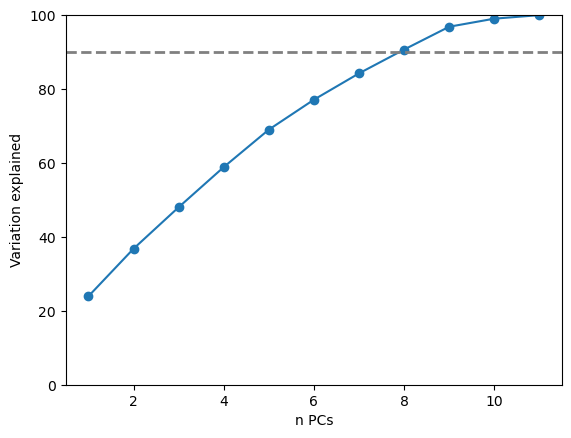

In [159]:
##Since some of the behavioral parameters that were tracked are correlated, PCA can help reduce the 
#number of dimensions needed

y_without_dist = y.loc[:, y.columns != 'dist']


# Standardize the data
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y_without_dist)

# Run PCA
pca = PCA()
principalComponents = pca.fit_transform(y_scaled)

cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

cum_explained_var = np.array(cum_explained_var)

principalDf = pd.DataFrame(data = principalComponents, 
                          columns=['PC%s' % _ for _ in range(1,len(y_without_dist.columns)+1)],
                          index = y_without_dist.index)

#Plot
plt.plot(np.arange(1, len(cum_explained_var) + 1), cum_explained_var * 100, marker='o')

# Customize plot
plt.xlabel('n PCs')
plt.ylabel('Variation explained')
plt.ylim(0, 100)
plt.axhline(y=90, linestyle='--', color='gray', linewidth=2)

# Show plot
plt.show()

###### input the number of points that explain 90 percent of the variation (up to and including the point past the dashed grey line)

In [160]:
variation_points = int(input("Please input the number of points that explain 90 percent of the variation: "))

#Get pca loadings
##The first 8 pcs tend to capture the majority of variation in larval input parameters
s = principalDf.iloc[:,:variation_points]

Please input the number of points that explain 90 percent of the variation: 8


### Save Point

In [161]:
with open(f"{wd}/{experiment_name}_PCA_{experiment_date}.pkl", "wb") as f:
    pickle.dump(s, f)

# Get feature windows of desired size and run UMAP

In [162]:
#Get windows (here using a window size of 8, recommended for larval behavior)
#This step takes a while to load, but will show progress after about a minute

win = tf.get_windows(s, window_size = 8).transpose()


#Run umap
u = umap.UMAP(verbose=True).fit_transform(win)

UMAP( verbose=True)
Sun Apr 20 17:29:27 2025 Construct fuzzy simplicial set
Sun Apr 20 17:29:27 2025 Finding Nearest Neighbors
Sun Apr 20 17:29:27 2025 Building RP forest with 26 trees
Sun Apr 20 17:29:28 2025 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	Stopping threshold met -- exiting after 7 iterations
Sun Apr 20 17:29:32 2025 Finished Nearest Neighbor Search
Sun Apr 20 17:29:33 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Apr 20 17:30:11 2025 Finished embedding


In [33]:
#Extract UMAP 2d layout
layout = pd.DataFrame({'x': u[:, 1], 'y': u[:, 0]}, index = win.index)

#Bin (64x64 grid ('n_bins' option) recommended)
layout = tf.bin_umap(layout, n_bins = 64)["layout"]

#Add trial
layout['trial'] = layout.index.str.split('.').str[0]

#Add time
layout['time'] = layout.index.str.split('.').str[1]

#Add id
layout['id'] = layout['trial'] + "_" + layout['time']

#Add condition
layout['condition'] = layout['trial'].str.split("_").str[0]

### Save Point

In [34]:
with open(f"{wd}/{experiment_name}_windowsize_8_{experiment_date}.pkl", "wb") as f:
    pickle.dump(layout, f)

# Analyzing UMAP behavior space

### Open saved data (this step can be accessed at any point after analysis above is run once)

In [7]:
#Load layout (wherever and with whichever name you decide to use)
with open(f"{wd}/{experiment_name}_windowsize_8_{experiment_date}.pkl", "rb") as f:
    layout = pickle.load(f)

### Scatter Plot 1

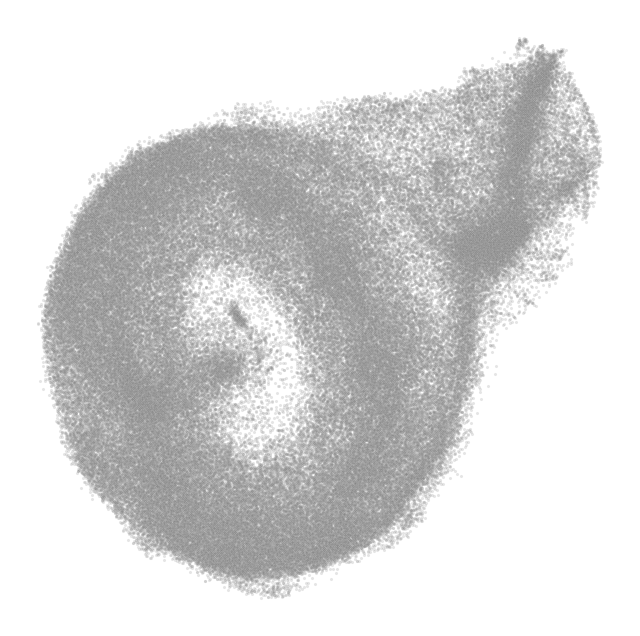

In [10]:
#Plot 2d layout of UMAP behavior space
plt.close()

plt.figure(figsize=(8,8))
ax1 = sns.scatterplot(x='x', y='y', data=layout, alpha=0.2, s = 5, color = 'grey')
plt.axis('off')

plt.show()

### Line Plot

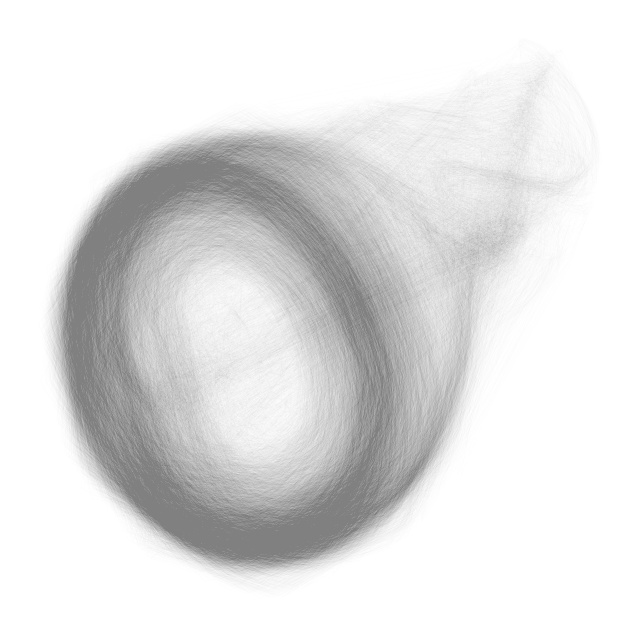

In [98]:
#Plot 2d structure of UMAP behavior space
plt.close()

plt.figure(figsize=(8, 8))
ax2 = sns.lineplot(x='x', y='y', data=layout, sort=False, linewidth=0.004, color='grey', estimator=None, alpha = 1)
plt.axis('off')

plt.show()

### Density Plot

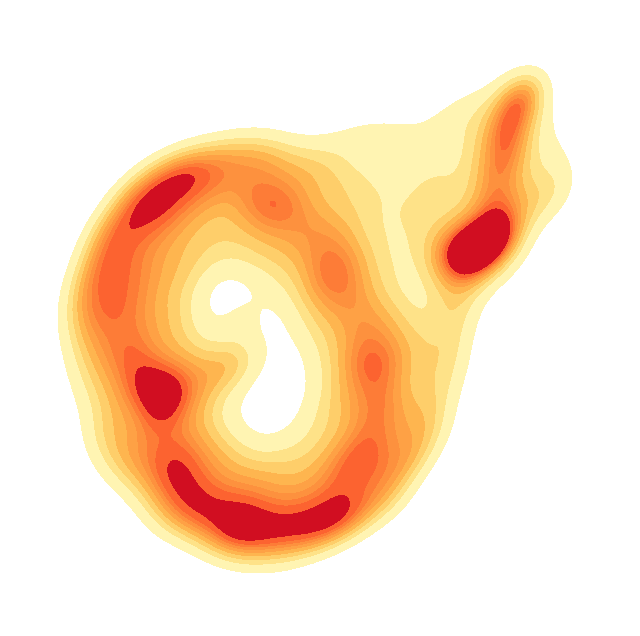

In [108]:
#Plot 2d probability density function of behavior space

plt.close()

plt.figure(figsize=(8, 8))
ax3 = sns.kdeplot(x='x', y='y', data=layout, fill=True, cmap="YlOrRd", bw_adjust = 1, levels = 10)
plt.axis('off')

plt.show()

# Analyzing input features (e.g. radius, spine length) as a function of behavior space

### Open saved data

In [8]:
#Load features (wherever and with whichever name you decide to use)
with open(f"{wd}/{experiment_name}_features_{experiment_date}.pkl", "rb") as f:
    features = pickle.load(f)

In [9]:
#Match features to the rownames of the layout file (i.e. making sure they represent the same timepoints)
features = features.reindex(layout.index)

#Combine
layout = pd.concat([layout, features], axis=1)

#Correlation between layout xy position and features
cor_x = layout.iloc[:, 10:23].apply(lambda col: np.corrcoef(layout['x'], col)[0, 1])
print("Correlation with x:\n", cor_x)

# Correlation between layout y position and features
cor_y = layout.iloc[:, 10:23].apply(lambda col: np.corrcoef(layout['y'], col)[0, 1])
print("\nCorrelation with y:\n", cor_y)

Correlation with x:
 area        -0.261726
bending      0.296590
velocity    -0.381918
spine       -0.341093
radius_1     0.213076
radius_2     0.068308
radius_3    -0.102964
perimeter   -0.316506
head_vr      0.050917
mom_vr       0.106903
tail_vr      0.057756
dist        -0.006947
dtype: float64

Correlation with y:
 area         0.318713
bending      0.317020
velocity    -0.429285
spine        0.362268
radius_1     0.144025
radius_2    -0.304976
radius_3    -0.357787
perimeter    0.376138
head_vr     -0.081668
mom_vr       0.027857
tail_vr      0.046865
dist        -0.000772
dtype: float64


### Plot Behavior Space by Feature Correlation

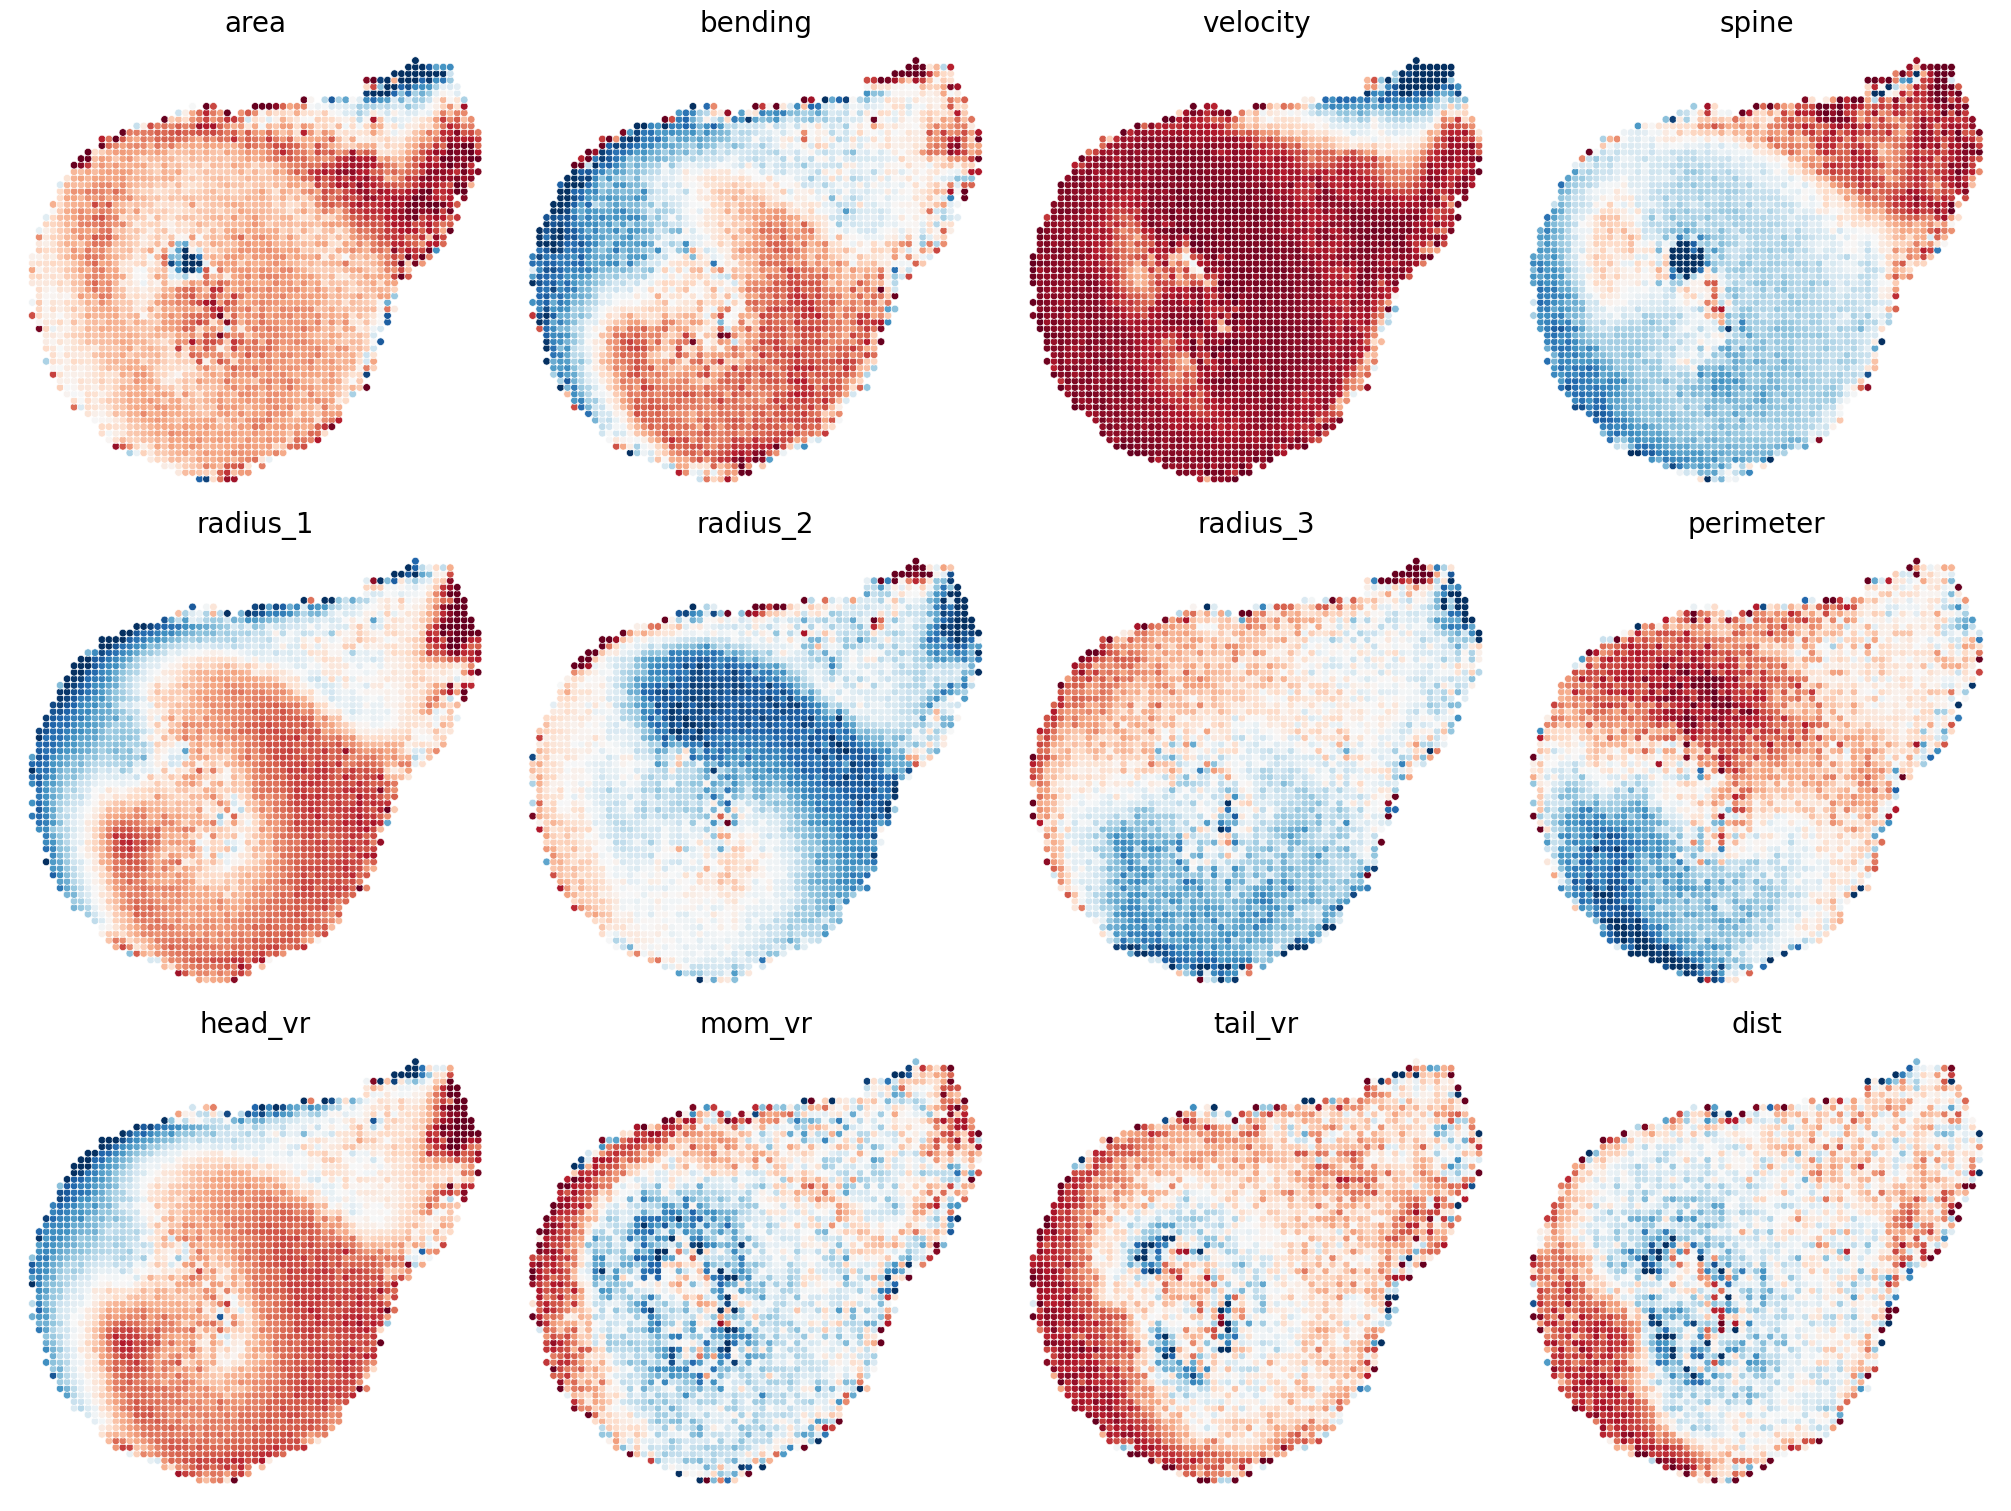

In [343]:
#Plotting features as means of layout bins

lst_feats = layout.columns.values.tolist()[26:]

# Split the DataFrame into bins based on 'xy_new'
x = layout.groupby('xy_new')

# Create subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), constrained_layout=True)
axs = axs.flatten()

# Plotting features as means of layout bins
for idx, i in enumerate(range(25, 37)):
    z = x.apply(lambda group: round(group.iloc[:, i].mean(), 2))
    z = z.clip(z.quantile(0.01), z.quantile(0.99))

    if z.min() > 0 or z.max() < 0:
        norm = Normalize(vmin=z.min(), vmax=z.max())
        cmap = 'Reds'
    else:
        norm = Normalize(vmin=z.min(), vmax=z.max())
        cmap = 'RdBu'
    
    xy_coords = [coord.split('_') for coord in z.index]
    x_coords = [int(coord[0]) for coord in xy_coords]
    y_coords = [int(coord[1]) for coord in xy_coords]

    sns.scatterplot(x=x_coords, y=y_coords,hue=z,palette=sns.color_palette(cmap, as_cmap=True), hue_norm=norm,
                    s=30,legend=False, ax=axs[idx], alpha = 1)
    axs[idx].set_title(lst_feats[idx], fontsize = 20)
    axs[idx].axis('off')

# Population-level variation (via time spent per bin)

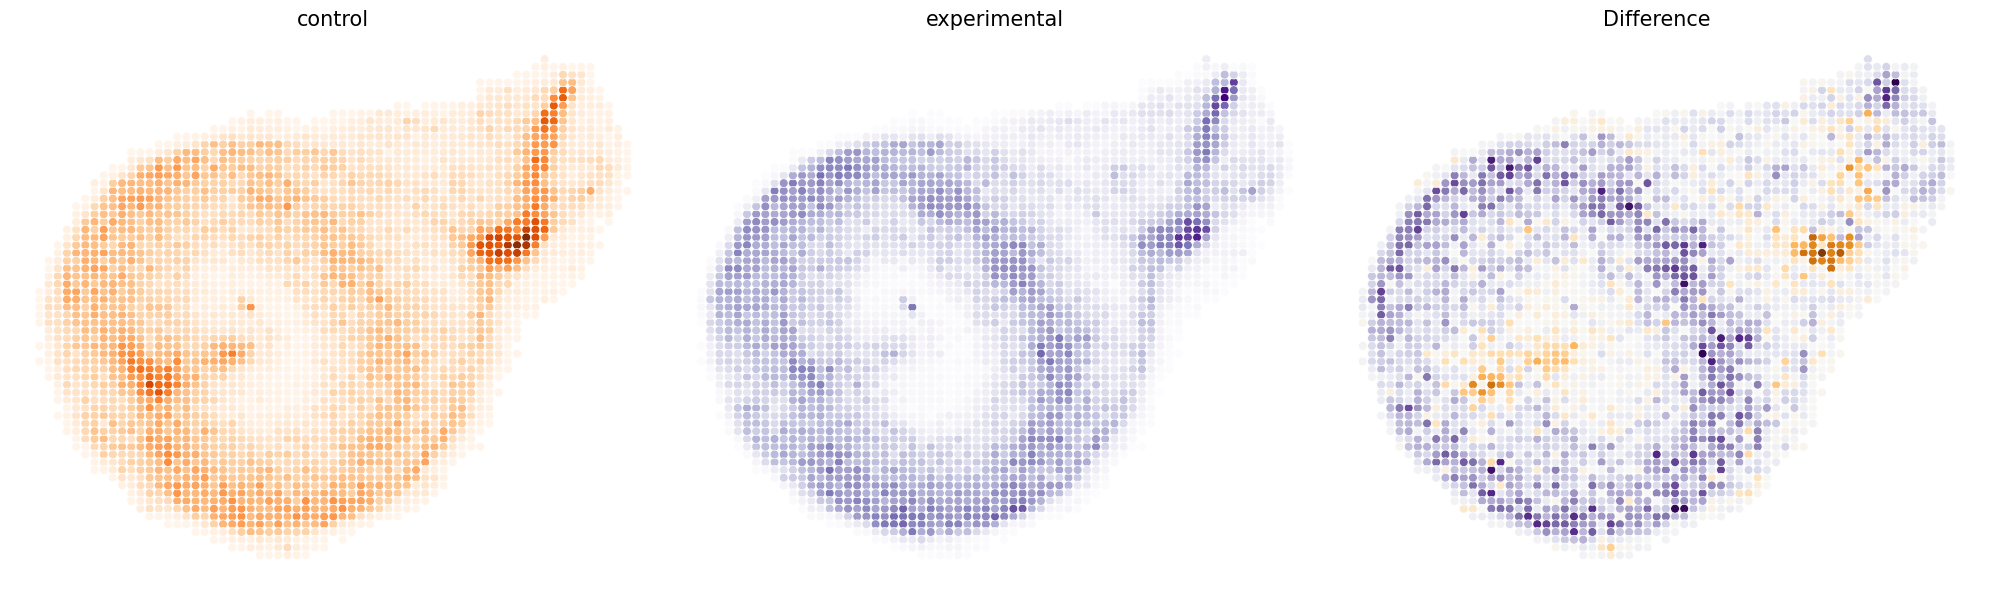

In [339]:
condition = {k: v for k, v in layout.groupby('condition')}

b = layout['xy_new'].unique()
xy_coords = [coord.split('_') for coord in b]
x_coords = [int(coord[0]) for coord in xy_coords]
y_coords = [int(coord[1]) for coord in xy_coords]

props = {}

for cond_name, df in condition.items():
    z = []
    total_rows = len(df)
    for bins in b:
        proportion = (df['xy_new'] == bins).sum() / total_rows
        z.append(proportion)
    props[cond_name] = np.round(np.array(z) / np.max(z), 2)

values = np.round(np.arange(0, 1.01, 0.01), 2)
cmaps = ["Oranges", "Purples"]

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Generate plots for each condition
for idx, (cond_name, values) in enumerate(props.items()):

    rounded_vals = np.round(values, 2)

    sns.scatterplot(x=x_coords, y=y_coords, hue = rounded_vals, palette=cmaps[idx], legend=False, ax=axs[idx], 
                    s = 40)
    axs[idx].set_title(cond_name, fontsize=15, fontweight='normal')
    axs[idx].axis('off')
    

cond_names = list(props.keys())
d = props[cond_names[0]] - props[cond_names[1]]
d = np.clip(d, -0.4, 0.4)

diff_df = pd.DataFrame({
    "x": x_coords,
    "y": y_coords,
    "diff": np.round(d, 2)
})

sns.scatterplot(data=diff_df, x="x", y="y", hue="diff", palette="PuOr_r", hue_norm=Normalize(vmin=-0.4, vmax=0.4),
                s=40, legend=False, ax=axs[2])
axs[2].set_title("Difference", fontsize=15, fontweight='normal')
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Louvain clustering

/var/folders/4d/c5srbhf568746lv5k5b9qlth0000gn/T/ipykernel_63294/62192620.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Spectral", len(unique_clusters))


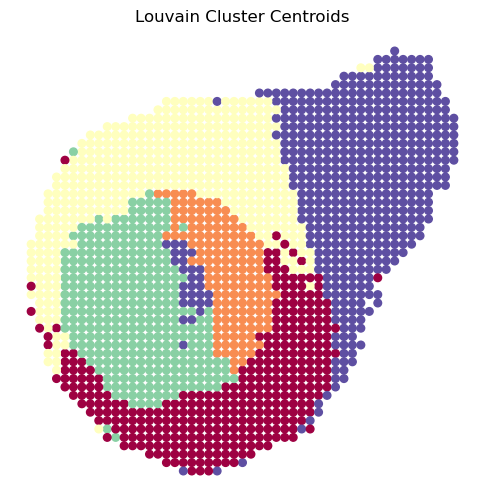

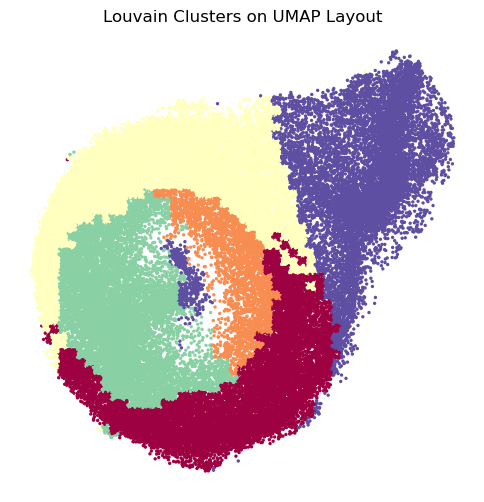

In [13]:
layout = tf.bin_umap(layout, n_bins=50)["layout"]

edges = list(zip(layout['xy_new'].iloc[:-1], layout['xy_new'].iloc[1:]))
g = nx.Graph()
g.add_edges_from(edges)

partition = community.best_partition(g)

xy_split = [xy.split('_') for xy in partition.keys()]
x_coords = [int(xy[0]) for xy in xy_split]
y_coords = [int(xy[1]) for xy in xy_split]

cluster_ids = list(partition.values())
unique_clusters = sorted(set(cluster_ids))
cmap = get_cmap("Spectral", len(unique_clusters))
cluster_colors = [to_hex(cmap(i)) for i in cluster_ids]

plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, c=cluster_colors, s=30)
plt.axis('off')
plt.title("Louvain Cluster Centroids")
plt.show()

layout['louvain_cluster'] = layout['xy_new'].map(partition)

sample = layout.iloc[:50000].copy()
cluster_colors_sample = [to_hex(cmap(layout.loc[i, 'louvain_cluster']))
                         if pd.notna(layout.loc[i, 'louvain_cluster']) else '#CCCCCC' for i in sample.index]

plt.figure(figsize=(6, 6))
plt.scatter(sample.iloc[:, 0], sample.iloc[:, 1], c=cluster_colors_sample, s=2)
plt.axis('off')
plt.title("Louvain Clusters on UMAP Layout")
plt.show()

# Analyzing feature distributions in Louvain clusters